In [58]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
# verdict_group_batch = "raljs5b"
# verdict_group_batch = "orz1gnj"
# verdict_group_batch = "5ot6r19"
verdict_group_batch = "83284bs"
# verdict_group_batch = "7i08qzy"
# verdict_group_batch = "u4efe0h"
# verdict_group_batch = "l93ijir"
# verdict_group_batch = "i0rf9mt"
# verdict_group_batch = "4h2rah9"

In [196]:
with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
    data = json.load(f)

verdict_ids = []
for run in data["runs"]:
    verdict_ids.append(run['verdict_run_id'])

In [197]:
data

{'group_run_id': '83284bs',
 'datetime': '2025-12-04T14:06:45.409837',
 'duration_seconds': 269.6296830177307,
 'runs_per_combination': 1,
 'judge_models': ['google/gemma-3-12b-it',
  'google/gemma-3-27b-it',
  'meta-llama/llama-3-8b-instruct',
  'meta-llama/llama-3.1-70b-instruct',
  'meta-llama/llama-3.1-405b-instruct',
  'meta-llama/llama-3.3-70b-instruct',
  'meta-llama/llama-4-scout',
  'meta-llama/llama-4-maverick',
  'openai/gpt-3.5-turbo',
  'qwen/qwen-2.5-7b-instruct',
  'qwen/qwen-2.5-72b-instruct'],
 'debate_run_ids': ['ts9ga4y'],
 'runs': [{'model': 'google/gemma-3-27b-it',
   'debate_run_id': 'ts9ga4y',
   'run_idx': 0,
   'verdict_run_id': 'cpq3gs0'},
  {'model': 'meta-llama/llama-3-8b-instruct',
   'debate_run_id': 'ts9ga4y',
   'run_idx': 0,
   'verdict_run_id': '5norje1'},
  {'model': 'meta-llama/llama-3.3-70b-instruct',
   'debate_run_id': 'ts9ga4y',
   'run_idx': 0,
   'verdict_run_id': 'tdiaxz7'},
  {'model': 'google/gemma-3-12b-it',
   'debate_run_id': 'ts9ga4y',
 

In [198]:
all_df = prepare_df(specific_verdict_ids=verdict_ids)

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  config_df = pd.json_normalize(df['config'])


In [199]:
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids)]
verdicts_df.shape

(1901, 87)

In [200]:
verdicts_df[['verdict_run_id_verdicts', 'config_debate_run_id_verdicts', 'config_judge_model_verdicts']].value_counts()

verdict_run_id_verdicts  config_debate_run_id_verdicts  config_judge_model_verdicts       
8pd0lap                  ts9ga4y                        qwen/qwen-2.5-72b-instruct            195
cpq3gs0                  ts9ga4y                        google/gemma-3-27b-it                 195
nuomvs4                  ts9ga4y                        meta-llama/llama-3.1-70b-instruct     195
ysbesw4                  ts9ga4y                        google/gemma-3-12b-it                 195
tdiaxz7                  ts9ga4y                        meta-llama/llama-3.3-70b-instruct     194
f0r7cda                  ts9ga4y                        openai/gpt-3.5-turbo                  193
5norje1                  ts9ga4y                        meta-llama/llama-3-8b-instruct        188
w56p1ei                  ts9ga4y                        meta-llama/llama-3.1-405b-instruct    188
nktsqy3                  ts9ga4y                        meta-llama/llama-4-scout              177
uss67qo                  ts

In [201]:
# Showing that repetitions actually have consideralbe variability - 90% in this case - even though average verdict performance come out similar (flipping)

# set1 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == 'zv74feq']
# set2 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '4j31cg4']

# merge = set1[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']].merge(set2[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']], on=['question_idx_debates'])

# (merge['is_correct_verdict_x'] == merge['is_correct_verdict_y']).sum() / merge.shape[0]


In [202]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.936170,0.534759,0.648936,176,100,122,188,188,187,188,0.436170,0.284439,0.401411,0.114177,5norje1
1,0.958333,0.541667,0.625000,23,13,15,24,24,24,24,0.708333,0.200000,0.416667,0.083333,5svjjw4
2,0.933333,0.676923,0.800000,182,132,156,195,195,195,195,0.579487,0.480000,0.256410,0.123077,8pd0lap
3,0.933333,0.641026,0.702564,182,125,137,195,195,195,195,0.451282,0.210526,0.292308,0.061538,cpq3gs0
4,0.932642,0.507772,0.637306,180,98,123,193,193,193,193,0.683938,0.304878,0.424870,0.129534,f0r7cda
5,0.954802,0.697143,0.819209,169,122,145,177,177,175,177,0.581921,0.473750,0.257659,0.122066,nktsqy3
6,0.933333,0.656410,0.789744,182,128,154,195,195,195,195,0.610256,0.481481,0.276923,0.133333,nuomvs4
7,0.932990,0.675258,0.850515,181,131,165,194,194,194,194,0.551546,0.680000,0.257732,0.175258,tdiaxz7
8,0.929936,0.772727,0.891720,146,119,140,157,157,154,157,0.464968,0.756906,0.157209,0.118992,uss67qo
9,0.930851,0.673797,0.808511,175,126,152,188,188,187,188,0.601064,0.524068,0.257054,0.134714,w56p1ei


In [208]:
100/187

0.5347593582887701

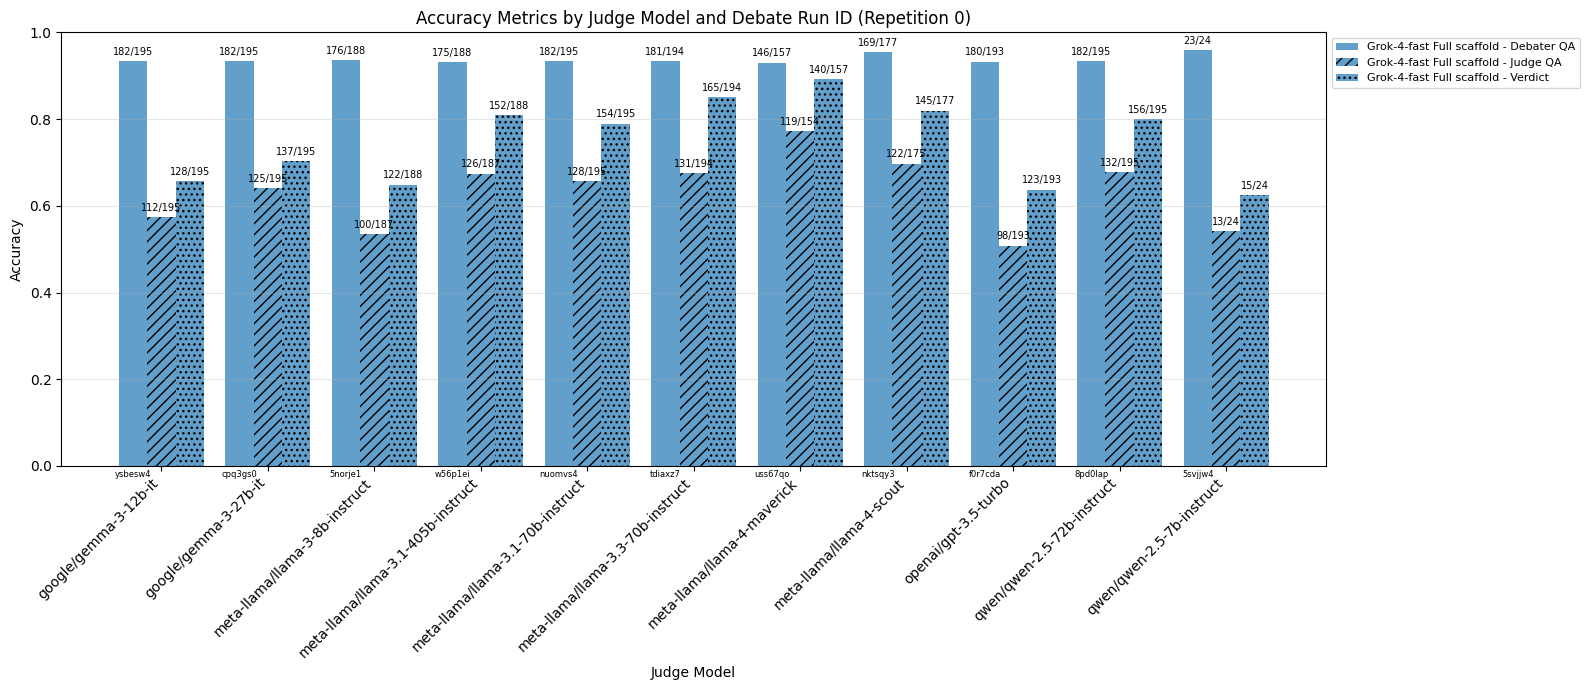

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

debate_run_id_labels = {
    'egkyot4': 'Gemini-3-pro Full scaffold',
    'ts9ga4y': 'Grok-4-fast Full scaffold',
    'txd06z5': 'Grok-4-fast Minimal scaffold',
    'wcsck4w': 'gpt-4o-mini Full scaffold',
    'yn1vu8h': 'gpt-4o-mini Minimal scaffold'
}

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

metrics = ['debater_qa_acc', 'judge_qa_acc', 'verdict_acc']
metric_labels = ['Debater QA', 'Judge QA', 'Verdict']

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    debate_run_ids = sorted(plot_data['debate_run_id'].unique())
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    n_metrics = len(metrics)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (n_debates * n_metrics)
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_debates))
    hatches = ['', '///', '...']
    
    metric_x_y_map = {
        'debater_qa_acc': ('debater_qa_n_correct', 'n_debater_qa_not_null'),
        'judge_qa_acc': ('judge_qa_n_correct', 'n_judge_qa_not_null'),
        'verdict_acc': ('verdict_n_correct', 'n_verdict_not_null')
    }
    
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
            values = []
            verdict_run_ids = []
            x_values = []
            y_values = []
            for judge_model in judge_models:
                row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
                if len(row) > 0:
                    values.append(row[metric].values[0])
                    verdict_run_ids.append(row['verdict_run_id'].values[0])
                    x_field, y_field = metric_x_y_map[metric]
                    x_values.append(int(row[x_field].values[0]))
                    y_values.append(int(row[y_field].values[0]))
                else:
                    values.append(0)
                    verdict_run_ids.append('')
                    x_values.append(0)
                    y_values.append(0)
            
            offset = (i - n_debates / 2 + 0.5) * (group_width / n_debates) + (j - n_metrics / 2 + 0.5) * width
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}" if j == 0 else ""
            bars = ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.7, hatch=hatches[j])
            
            for k, (bar, verdict_run_id, x_val, y_val) in enumerate(zip(bars, verdict_run_ids, x_values, y_values)):
                if verdict_run_id and j == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, -0.01, verdict_run_id,
                           ha='center', va='top', fontsize=6)
                if x_val > 0 or y_val > 0:
                    pct = int(x_val / y_val * 100) if y_val > 0 else 0
                    label_text = f"{pct}% ({x_val}/{y_val})"
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, label_text,
                           ha='center', va='bottom', fontsize=7)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy Metrics by Judge Model and Debate Run ID (Repetition {run_idx})')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, metric_label in enumerate(metric_labels):
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}"
            legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, hatch=hatches[j], label=label))
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


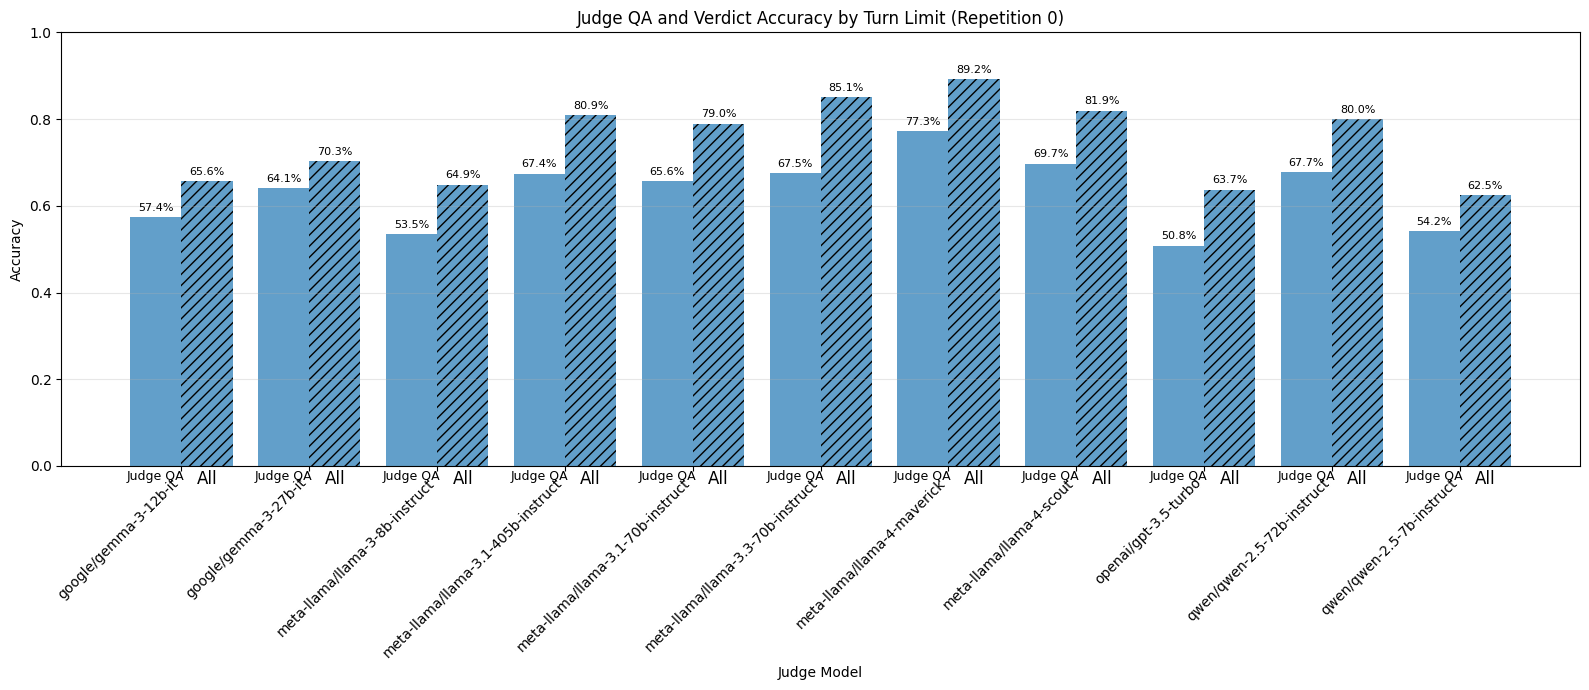

In [ ]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique() if x != 0])
        
    else:
        upto_turns_list = [None]
    
    n_judges = len(judge_models)
    n_turns = len(upto_turns_list)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (1 + n_turns)
    
    bar_color = plt.cm.tab10(0)
    chose_idx_0_color = plt.cm.tab10(1)
    hatches = ['', '///']
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    judge_qa_values = []
    for judge_model in judge_models:
        rows = plot_data[plot_data['model'] == judge_model]
        if len(rows) > 0:
            avg_value = rows['judge_qa_acc'].mean()
            judge_qa_values.append(avg_value)
        else:
            judge_qa_values.append(0)
    
    judge_qa_offset = -group_width / 2 + width / 2
    bars_judge_qa = ax.bar(x + judge_qa_offset, judge_qa_values, width, label='Judge QA', color=bar_color, alpha=0.7, hatch=hatches[0])
    
    for bar in bars_judge_qa:
        ax.text(bar.get_x() + bar.get_width() / 2, -0.01, 'Judge QA',
               ha='center', va='top', fontsize=9)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        verdict_values = []
        chose_idx_0_values = []
        for judge_model in judge_models:
            rows = turn_data[turn_data['model'] == judge_model]
            if len(rows) > 1:
                raise Exception('Check why rows greater than 1')
            verdict_values.append(rows.iloc[0]['verdict_acc'])
            chose_idx_0_values.append(rows.iloc[0]['verdict_chose_idx_0'])
            # if len(rows) > 0:
            #     print(len(rows))
            #     avg_value = rows['verdict_acc'].mean()
            #     verdict_values.append(avg_value)
            # else:
            #     verdict_values.append(0)

        
        offset = judge_qa_offset + width + i * width
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bars = ax.bar(x + offset, verdict_values, width, label=label, color=bar_color, alpha=0.7, hatch=hatches[1])
        
        # bars_chose_idx_0 = ax.bar(x + offset, chose_idx_0_values, width, color=chose_idx_0_color, alpha=0.4)
        
        for k, bar in enumerate(bars):
            turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
            ax.text(bar.get_x() + bar.get_width() / 2, -0.01, turn_label,
                   ha='center', va='top', fontsize=12)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    title = f'Judge QA and Verdict Accuracy by Turn Limit'
    if run_idx is not None:
        title += f' (Repetition {run_idx})'
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    

    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


In [183]:
verdicts_df.columns

Index(['config_debate_run_id_verdicts', 'config_judge_model_verdicts',
       'config_judge_reasoning_effort_verdicts',
       'config_judge_reasoning_max_tokens_verdicts',
       'config_judge_temperature_verdicts',
       'config_max_output_tokens_verdicts', 'config_max_threads_verdicts',
       'config_rerun_verdicts', 'config_skip_qa_verdicts',
       'config_specific_record_ids_verdicts', 'config_subset_n_verdicts',
       'config_upto_turns_verdicts', 'correct_idx_verdicts',
       'datetime_verdicts', 'debate_run_id_verdicts', 'error_message_verdicts',
       'judge_verdict_verdicts', 'options_str_verdicts', 'options_verdicts',
       'parsed_answer_verdicts', 'parsed_confidence_verdicts',
       'parsed_reasoning_verdicts', 'prompt_template_verdicts',
       'question_verdicts', 'record_id_verdicts', 'success_verdicts',
       'verdict_run_id_verdicts', 'config_dataset_filters.difficulty_debates',
       'config_dataset_filters.field_debates',
       'config_dataset_filters_deb

In [137]:
verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '0aw6bur']['correct_idx_debates'].value_counts(normalize=True)

correct_idx_debates
1.0    0.528205
0.0    0.471795
Name: proportion, dtype: float64

In [ ]:
verdicts_df[verdicts_df]